In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 11 04:13:14 2025

@author: phemb
"""

import numpy as np

class Generateur_Donnees:

    v = 20
    g = 0.1
    f_v = 0.001

    def __init__(self, vitesse_initiale = v, pesanteur = g, frottement_visqueux = f_v):

        self._v_0 = vitesse_initiale
        self._g = pesanteur
        self._f_v = frottement_visqueux

    def position_virtuelle(self,t):

        return np.where(- 0.5*self._g*t**2 + self._v_0 *t >= 0,- 0.5*self._g*t**2 + self._v_0 *t,0)

    def position_reelle(self,t):

        A = self._v_0/self._f_v + self._g/(self._f_v**2)
        B = - A

        return np.where(A+B*np.exp(-self._f_v*t)-(self._g/self._f_v)*t >= 0,A+B*np.exp(-self._f_v*t)-(self._g/self._f_v)*t,0)

    def set_vitesse_initiale(self,vitesse):

        self._v_0 = vitesse

    def set_pesanteur(self,coefficient):

        self._g = coefficient

    def set_frottement_visqueux(self,coefficient):

        self._f_v = coefficient

In [3]:
# --- MAIN: ÉTAPE 1 (Analyse & Visualisation) ---

# 1. Instanciation et génération
gen = Generateur_Donnees()

# On génère un temps suffisamment long pour voir la chute complète
# v0=20, g=0.1 -> temps de vol approx 400s
t = np.linspace(0, 450, 1000)

pos_virtuelle = gen.position_virtuelle(t)
pos_reelle = gen.position_reelle(t)

# 2. Calcul de l'Ignorance (La cible pour notre futur IA)
# Ignorance = Ce qui manque au modèle virtuel pour être égal au réel
ignorance = pos_reelle - pos_virtuelle



In [4]:
import plotly.graph_objects as go

fig_traj = go.Figure()

fig_traj.add_trace(
    go.Scatter(
        x=t,
        y=pos_virtuelle,
        name="Virtuel (Simplifié)",
        line=dict(dash='dash', color='blue')
    )
)

fig_traj.add_trace(
    go.Scatter(
        x=t,
        y=pos_reelle,
        name="Réel (Avec Frottement)",
        line=dict(color='green')
    )
)

fig_traj.update_layout(
    title="Comparaison des Trajectoires",
    xaxis_title="Temps (s)",
    yaxis_title="Hauteur (m)",
    hovermode="x unified",
    height=500
)

fig_traj.show()


In [5]:
fig_err = go.Figure()

fig_err.add_trace(
    go.Scatter(
        x=t,
        y=ignorance,
        name="Ignorance (Erreur)",
        line=dict(color='red')
    )
)

fig_err.update_layout(
    title="Visualisation de l'Ignorance (Erreur de Modélisation)",
    xaxis_title="Temps (s)",
    yaxis_title="Delta (m)",
    hovermode="x unified",
    height=500
)

fig_err.show()


In [12]:
# --- IMPORTS ---
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# --- PRÉPARATION GLOBALE DES DONNÉES ---

# 1. Reshape
X = t.reshape(-1, 1)
y = ignorance

# 2. Split
# On sépare les données BRUTES. On ne scale pas encore.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Définition du Pipeline (La correction majeure)
# Au lieu de scaler manuellement X_train, on définit les étapes.
# Le scaler est intégré ici : il s'ajustera automatiquement sur chaque "fold" d'entraînement.
modele_pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Étape 1 : Normalisation
    ('poly', PolynomialFeatures()),     # Étape 2 : Features polynomiales (si nécessaire)
    ('model', LinearRegression())       # Étape 3 : Le modèle (à changer selon besoin)
])

print(f"Données prêtes : {X_train.shape[0]} points d'entraînement, {X_test.shape[0]} points de test.")
print("Le scaling est désormais encapsulé dans 'modele_pipeline' pour éviter le data leakage.")

Données prêtes : 800 points d'entraînement, 200 points de test.
Le scaling est désormais encapsulé dans 'modele_pipeline' pour éviter le data leakage.


In [18]:
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

print("--- i) Optimisation du modèle Polynomial ---")

# 1. OPTIMISATION (GridSearch)
# On teste les degrés de 1 à 6
param_grid = {'poly__degree': np.arange(1, 30)}

# On utilise le pipeline défini précédemment
# cv=5 : Validation croisée à 5 plis
grid_poly = GridSearchCV(modele_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# IMPORTANT : On fit sur X_train BRUT (le pipeline scalera tout seul)
grid_poly.fit(X_train, y_train)

best_degree = grid_poly.best_params_['poly__degree']
best_model_poly = grid_poly.best_estimator_
print(f"Meilleur degré trouvé : {best_degree}")



--- i) Optimisation du modèle Polynomial ---
Meilleur degré trouvé : 28


In [19]:

# 2. ÉVALUATION
# On prédit sur X_test BRUT
y_pred_poly = best_model_poly.predict(X_test)

rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

# Erreur relative moyenne (ajout d'un epsilon pour éviter division par zéro)
epsilon = 1e-6
relative_error_poly = np.mean(np.abs(y_test - y_pred_poly) / (np.abs(y_test) + epsilon)) * 100

print(f"RMSE : {rmse_poly:.4f} m")
print(f"R2 Score : {r2_poly:.5f}")
print(f"Erreur Relative Moyenne : {relative_error_poly:.2f} %")


RMSE : 3.6911 m
R2 Score : 0.99947
Erreur Relative Moyenne : 61703295.29 %


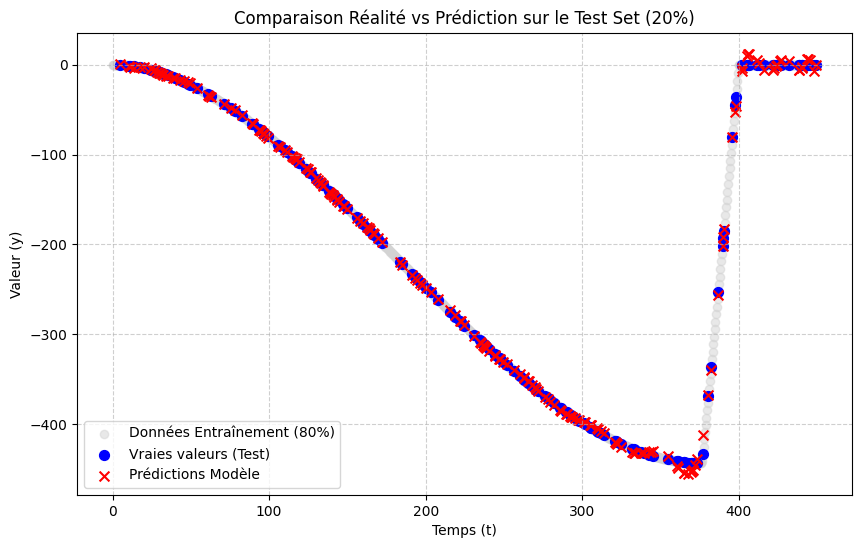

In [20]:
import matplotlib.pyplot as plt

# --- VISUALISATION ---
plt.figure(figsize=(10, 6))

# 1. On affiche les données d'entraînement en gris clair (pour le contexte)
plt.scatter(X_train, y_train, color='lightgray', label='Données Entraînement (80%)', alpha=0.5)

# 2. On affiche les VRAIES valeurs du set de test en Bleu
plt.scatter(X_test, y_test, color='blue', label='Vraies valeurs (Test)', s=50)

# 3. On affiche les valeurs PRÉDITES par ton modèle en Rouge
# On utilise un marqueur différent (ex: 'x') pour bien les distinguer si elles se chevauchent
plt.scatter(X_test, y_pred_poly, color='red', marker='x', label='Prédictions Modèle', s=50)

plt.title("Comparaison Réalité vs Prédiction sur le Test Set (20%)")
plt.xlabel("Temps (t)")
plt.ylabel("Valeur (y)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [21]:
# 3. TRACÉ (Validation Visuelle)
# On génère la prédiction sur tout l'axe t pour voir la courbe complète
# X est déjà défini (t.reshape(-1, 1))
ignorance_pred_full = best_model_poly.predict(X)
pos_hybride_poly = pos_virtuelle + ignorance_pred_full

fig_poly = go.Figure()

# A. Modèle Virtuel
fig_poly.add_trace(go.Scatter(x=t, y=pos_virtuelle, name="Virtuel", line=dict(dash='dash', color='blue')))

# B. Réalité (Target)
fig_poly.add_trace(go.Scatter(x=t, y=pos_reelle, name="Réel (Target)", line=dict(color='green', width=4), opacity=0.4))

# C. Hybride (Polynomial)
fig_poly.add_trace(go.Scatter(x=t, y=pos_hybride_poly, name=f"Hybride (Poly deg={best_degree})", line=dict(dash='dot', color='red')))

fig_poly.update_layout(
    title=f"Validation Régression Polynomiale (Degré {best_degree})<br>RMSE={rmse_poly:.2f}m | R2={r2_poly:.4f}",
    xaxis_title="Temps (s)",
    yaxis_title="Position (m)",
    hovermode="x unified"
)
fig_poly.show()

In [22]:
# --- 3. TRACÉ MODIFIÉ (Comparaison des Ignorances) ---
# On génère la prédiction sur tout l'axe t pour voir la courbe complète
# X est déjà défini (t.reshape(-1, 1))

fig_ign_poly = go.Figure()

# A. Ignorance Réelle (Target)
# C'est la vérité terrain que le modèle essaie d'atteindre
fig_ign_poly.add_trace(go.Scatter(
    x=t,
    y=ignorance, # C'est votre variable 'ignorance' calculée au début
    name="Ignorance Réelle (Target)",
    line=dict(color='red', width=4),
    opacity=0.5
))

# B. Ignorance Prédite (Polynomial)
# C'est ce que le modèle a compris
fig_ign_poly.add_trace(go.Scatter(
    x=t,
    y=ignorance_pred_full,
    name=f"Ignorance Prédite (Poly deg={best_degree})",
    line=dict(dash='dot', color='blue', width=2)
))

fig_ign_poly.update_layout(
    title=f"Validation du Modèle : Comparaison des Ignorances (Degré {best_degree})<br>RMSE sur le Test={rmse_poly:.2f}m",
    xaxis_title="Temps (s)",
    yaxis_title="Ignorance (mètres)",
    hovermode="x unified"
)

fig_ign_poly.show()

XGBOOST

In [23]:
# --- IMPORTS ---
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
import numpy as np

# --- PRÉPARATION GLOBALE DES DONNÉES (Rappel) ---
# X et y sont supposés existants (t.reshape(-1, 1) et ignorance)
# On s'assure d'avoir le même split pour comparer équitablement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Définition du Pipeline XGBoost
# Pas de 'poly' ici, XGBoost apprend les non-linéarités via ses arbres
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Étape 1 : Normalisation (aide à la convergence)
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42)) # Étape 2 : Le modèle XGBoost
])

print(f"Pipeline XGBoost prêt.")

Pipeline XGBoost prêt.


In [24]:
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

print("--- ii) Optimisation du modèle XGBoost ---")

# 1. OPTIMISATION (GridSearch)
# On teste le nombre d'arbres et leur profondeur
param_grid_xgb = {
    'model__n_estimators': [50, 100, 200], # Nombre d'arbres
    'model__max_depth': [3, 5, 7],         # Complexité de chaque arbre
    'model__learning_rate': [0.01, 0.1]    # Vitesse d'apprentissage
}

# cv=5 : Validation croisée à 5 plis
grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')

# On fit sur X_train (le pipeline gère le scaling)
grid_xgb.fit(X_train, y_train)

best_params_xgb = grid_xgb.best_params_
best_model_xgb = grid_xgb.best_estimator_

print(f"Meilleurs paramètres trouvés : {best_params_xgb}")

--- ii) Optimisation du modèle XGBoost ---
Meilleurs paramètres trouvés : {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}


In [25]:
# 2. ÉVALUATION
# On prédit sur X_test BRUT
y_pred_xgb = best_model_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Erreur relative moyenne
epsilon = 1e-6
relative_error_xgb = np.mean(np.abs(y_test - y_pred_xgb) / (np.abs(y_test) + epsilon)) * 100

print(f"RMSE : {rmse_xgb:.4f} m")
print(f"R2 Score : {r2_xgb:.5f}")
print(f"Erreur Relative Moyenne : {relative_error_xgb:.2f} %")

RMSE : 2.2223 m
R2 Score : 0.99981
Erreur Relative Moyenne : 18446.29 %


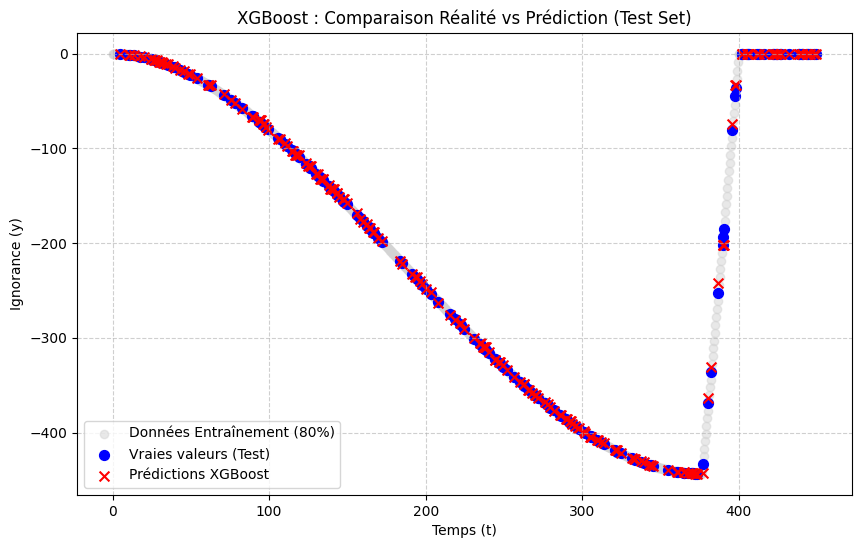

In [26]:
import matplotlib.pyplot as plt

# --- VISUALISATION ---
plt.figure(figsize=(10, 6))

# 1. Données d'entraînement (Contexte)
plt.scatter(X_train, y_train, color='lightgray', label='Données Entraînement (80%)', alpha=0.5)

# 2. Vraies valeurs (Test)
plt.scatter(X_test, y_test, color='blue', label='Vraies valeurs (Test)', s=50)

# 3. Prédictions XGBoost
plt.scatter(X_test, y_pred_xgb, color='red', marker='x', label='Prédictions XGBoost', s=50)

plt.title("XGBoost : Comparaison Réalité vs Prédiction (Test Set)")
plt.xlabel("Temps (t)")
plt.ylabel("Ignorance (y)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [27]:
# 3. TRACÉ (Validation Visuelle Trajectoire)
# On génère la prédiction sur tout l'axe t
ignorance_pred_full_xgb = best_model_xgb.predict(X)
pos_hybride_xgb = pos_virtuelle + ignorance_pred_full_xgb

fig_xgb = go.Figure()

# A. Modèle Virtuel
fig_xgb.add_trace(go.Scatter(x=t, y=pos_virtuelle, name="Virtuel", line=dict(dash='dash', color='blue')))

# B. Réalité (Target)
fig_xgb.add_trace(go.Scatter(x=t, y=pos_reelle, name="Réel (Target)", line=dict(color='green', width=4), opacity=0.4))

# C. Hybride (XGBoost)
# On récupère les params pour le label (ex: n_estimators)
n_est = best_params_xgb['model__n_estimators']
fig_xgb.add_trace(go.Scatter(x=t, y=pos_hybride_xgb, name=f"Hybride (XGBoost n={n_est})", line=dict(dash='dot', color='red')))

fig_xgb.update_layout(
    title=f"Validation XGBoost<br>RMSE={rmse_xgb:.2f}m | R2={r2_xgb:.4f}",
    xaxis_title="Temps (s)",
    yaxis_title="Position (m)",
    hovermode="x unified"
)
fig_xgb.show()

In [28]:
# --- 3. TRACÉ MODIFIÉ (Comparaison des Ignorances XGBoost) ---

fig_ign_xgb = go.Figure()

# A. Ignorance Réelle
fig_ign_xgb.add_trace(go.Scatter(
    x=t,
    y=ignorance,
    name="Ignorance Réelle (Target)",
    line=dict(color='red', width=4),
    opacity=0.5
))

# B. Ignorance Prédite (XGBoost)
fig_ign_xgb.add_trace(go.Scatter(
    x=t,
    y=ignorance_pred_full_xgb,
    name=f"Ignorance Prédite (XGBoost)",
    line=dict(dash='dot', color='blue', width=2)
))

fig_ign_xgb.update_layout(
    title=f"Validation XGBoost : Comparaison des Ignorances<br>RMSE sur le Test={rmse_xgb:.2f}m",
    xaxis_title="Temps (s)",
    yaxis_title="Ignorance (mètres)",
    hovermode="x unified"
)

fig_ign_xgb.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# On génère un dataset varié pour l'apprentissage (l'IA doit comprendre la physique)
X_train = []
y_train = []
gen = Generateur_Donnees()
t_span = np.linspace(0, 450, 50) # Temps courts pour entrainement rapide

np.random.seed(42)
for _ in range(200): # 200 Scénarios d'entrainement
    v = np.random.uniform(10, 50)
    g = np.random.uniform(0.05, 0.2)
    f = np.random.uniform(0.0005, 0.005)
    gen.set_params(v, g, f)
    pos_v = gen.position_virtuelle(t_span)
    pos_r = gen.position_reelle(t_span)
    ignorance = pos_r - pos_v # CIBLE

    for k in range(len(t_span)):
        X_train.append([t_span[k], v, g, f])
        y_train.append(ignorance[k])

X_train = np.array(X_train)
y_train = np.array(y_train)

# --- 2. CONFIGURATION FIGÉE (TEST) ---
# v = 20, g = 0.1, f_v = 0.001
t_test = np.linspace(0, 600, 600)
gen.set_params(20, 0.1, 0.001)
pos_v_test = gen.position_virtuelle(t_test)
pos_r_test = gen.position_reelle(t_test)
ignorance_reelle = pos_r_test - pos_v_test

X_test_fixed = np.column_stack((
    t_test,
    np.full_like(t_test, 20),
    np.full_like(t_test, 0.1),
    np.full_like(t_test, 0.001)
))

# --- 3. OPTIMISATION REGRESSION POLYNOMIALE ---
print("--- Optimisation Régression Polynomiale ---")

# Pipeline : Scaling -> Creation Polynomes -> Regression Lineaire
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('reg', LinearRegression())
])

# On teste les degrés 1 à 6
param_grid = {'poly__degree': [1, 2, 3, 4, 5, 6]}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_degree = grid.best_params_['poly__degree']
print(f"Meilleur degré trouvé : {best_degree}")





In [ ]:
# --- 4. ÉVALUATION (Partie i-a) ---
ignorance_pred = best_model.predict(X_test_fixed)
pos_hybride = pos_v_test + ignorance_pred

rmse = np.sqrt(mean_squared_error(ignorance_reelle, ignorance_pred))
r2 = r2_score(ignorance_reelle, ignorance_pred)
# Erreur relative moyenne (sur l'ignorance, en évitant la division par zero)
rel_err = np.mean(np.abs((ignorance_reelle - ignorance_pred) / (np.abs(ignorance_reelle) + 1e-6))) * 100

print(f"RMSE : {rmse:.4f} m")
print(f"R2 Score : {r2:.5f}")
print(f"Erreur Relative Moyenne : {rel_err:.2f} %")

In [ ]:
# --- 5. TRACÉ (Partie i-b) ---
plt.figure(figsize=(10, 6))
plt.plot(t_test, pos_v_test, '--b', label='Virtuel (Modèle simple)', alpha=0.6)
plt.plot(t_test, pos_r_test, '-g', label='Réel (Cible)', linewidth=2, alpha=0.5)
plt.plot(t_test, pos_hybride, ':r', label=f'Hybride (Poly deg={best_degree})', linewidth=2)

plt.title(f"Régression Polynomiale (Degré {best_degree})\nRMSE={rmse:.2f}m | R2={r2:.4f}")
plt.xlabel("Temps (s)")
plt.ylabel("Position (m)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('resultat_poly.png')
plt.show()

In [ ]:
# --- 2. CRÉATION DU "MEGA DATASET" (Question 5) ---
print("Génération du Dataset multi-paramètres en cours...")

X_list = []
y_list = []
gen = Generateur_Donnees()

# On crée 100 scénarios différents aléatoires
nb_scenarios = 500
t_base = np.linspace(0, 800, 800) # 100 points par courbe

for _ in range(nb_scenarios):
    # Paramètres aléatoires (Uniforme)
    v_rand = np.random.uniform(10, 50)   # Vitesse entre 10 et 50 m/s
    g_rand = np.random.uniform(0.05, 0.2) # Gravité variée
    f_rand = np.random.uniform(0.0005, 0.005) # Frottement varié

    # Mise à jour du générateur
    gen.set_vitesse_initiale(v_rand)
    gen.set_pesanteur(g_rand)
    gen.set_frottement_visqueux(f_rand)

    # Calcul des courbes
    pos_v = gen.position_virtuelle(t_base)
    pos_r = gen.position_reelle(t_base)
    ignorance = pos_r - pos_v

    # Stockage des données pour l'IA
    # Pour chaque instant t, l'IA doit connaitre le contexte (v, g, f)
    for i in range(len(t_base)):
        # Entrée : [Temps, Vitesse, Gravité, Frottement]
        X_list.append([t_base[i], v_rand, g_rand, f_rand])
        # Sortie : Ignorance correspondante
        y_list.append(ignorance[i])

X = np.array(X_list)
y = np.array(y_list)

print(f"Dataset créé : {len(X)} points d'entrainement.")


Génération du Dataset multi-paramètres en cours...
Dataset créé : 400000 points d'entrainement.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# --- 3. APPRENTISSAGE ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)





Score de généralisation (R²) : 1.0000
